In [1]:
import numpy as np
from cluster_algorithms import base_kmeans
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.spatial import Voronoi, voronoi_plot_2d
import time

In [2]:
data_files_path = '../data_files/data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM2.bkg.VProbes_EGAM7.GRL_v97/'
file_name       = 'data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM2.bkg.VProbes_EGAM7.GRL_v97_et0_eta0.npz'

plots_path      = '../clustering_plot/'
my_seed         = 13

In [3]:
jpsi_data = dict(np.load(data_files_path+file_name))
jpsi_data.keys()

dict_keys(['features', 'etBins', 'etaBins', 'etBinIdx', 'etaBinIdx', 'data', 'target'])

In [4]:
list_of_features = list(jpsi_data['features'])
print(list_of_features)

['avgmu', 'L2Calo_ring_0', 'L2Calo_ring_1', 'L2Calo_ring_2', 'L2Calo_ring_3', 'L2Calo_ring_4', 'L2Calo_ring_5', 'L2Calo_ring_6', 'L2Calo_ring_7', 'L2Calo_ring_8', 'L2Calo_ring_9', 'L2Calo_ring_10', 'L2Calo_ring_11', 'L2Calo_ring_12', 'L2Calo_ring_13', 'L2Calo_ring_14', 'L2Calo_ring_15', 'L2Calo_ring_16', 'L2Calo_ring_17', 'L2Calo_ring_18', 'L2Calo_ring_19', 'L2Calo_ring_20', 'L2Calo_ring_21', 'L2Calo_ring_22', 'L2Calo_ring_23', 'L2Calo_ring_24', 'L2Calo_ring_25', 'L2Calo_ring_26', 'L2Calo_ring_27', 'L2Calo_ring_28', 'L2Calo_ring_29', 'L2Calo_ring_30', 'L2Calo_ring_31', 'L2Calo_ring_32', 'L2Calo_ring_33', 'L2Calo_ring_34', 'L2Calo_ring_35', 'L2Calo_ring_36', 'L2Calo_ring_37', 'L2Calo_ring_38', 'L2Calo_ring_39', 'L2Calo_ring_40', 'L2Calo_ring_41', 'L2Calo_ring_42', 'L2Calo_ring_43', 'L2Calo_ring_44', 'L2Calo_ring_45', 'L2Calo_ring_46', 'L2Calo_ring_47', 'L2Calo_ring_48', 'L2Calo_ring_49', 'L2Calo_ring_50', 'L2Calo_ring_51', 'L2Calo_ring_52', 'L2Calo_ring_53', 'L2Calo_ring_54', 'L2Calo_ri

In [5]:
var_indexes = [list_of_features.index('avgmu'),
               list_of_features.index('L2Calo_et'),]

In [16]:
data_      = jpsi_data['data'][:, var_indexes]
mu_filter  = data_[:,0] <= 60
sgn_filter = jpsi_data['target'][mu_filter]==1
bkg_filter = jpsi_data['target'][mu_filter]==0
data_      = data_[mu_filter,:]
print(data_.shape)

(233256, 2)


In [17]:
sgn_choices_filter = np.random.choice(data_[sgn_filter].shape[0], size=300)
bkg_choices_filter = np.random.choice(data_[bkg_filter].shape[0], size=300)
choices_filter     = np.concatenate((sgn_choices_filter,bkg_choices_filter))

In [18]:
data_ = data_[choices_filter,:]
y     = jpsi_data['target'][choices_filter]
print(data_.shape)

(600, 2)


In [38]:
kmeans = base_kmeans(n_clusters=3)

In [53]:
%%time
kmeans.fit(data_, n_iter=50, tol=1e-5, breg_div='exp')

Begin K-means using exp divergence... 
Iteraction: 1
Iteraction: 2
Iteraction: 3
Iteraction: 4
Iteraction: 5
Iteraction: 6


/home/micaelverissimo/Workspace/information_geometry/bregman_clustering/python/cluster_algorithms.py:17: RuntimeWarning: overflow encountered in exp
  'exp'           : lambda u, v: (np.exp(u)-np.exp(v)-(u-v)*np.exp(v)).sum(),
/home/micaelverissimo/Workspace/information_geometry/bregman_clustering/python/cluster_algorithms.py:17: RuntimeWarning: invalid value encountered in subtract
  'exp'           : lambda u, v: (np.exp(u)-np.exp(v)-(u-v)*np.exp(v)).sum(),
/home/micaelverissimo/Workspace/information_geometry/bregman_clustering/python/cluster_algorithms.py:17: RuntimeWarning: invalid value encountered in multiply
  'exp'           : lambda u, v: (np.exp(u)-np.exp(v)-(u-v)*np.exp(v)).sum(),


Iteraction: 7
Iteraction: 8
Iteraction: 9
Iteraction: 10
Iteraction: 11
Iteraction: 12
Iteraction: 13
Iteraction: 14
Iteraction: 15
Iteraction: 16
Iteraction: 17
Iteraction: 18
Iteraction: 19
Iteraction: 20
Iteraction: 21
Iteraction: 22
Iteraction: 23
Iteraction: 24
Iteraction: 25
Iteraction: 26
Iteraction: 27
Iteraction: 28
Iteraction: 29
Iteraction: 30
Iteraction: 31
Iteraction: 32
Iteraction: 33
Iteraction: 34
Iteraction: 35
Iteraction: 36
Iteraction: 37
Iteraction: 38
Iteraction: 39
Iteraction: 40
Iteraction: 41
Iteraction: 42
Iteraction: 43
Iteraction: 44
Iteraction: 45
Iteraction: 46
Iteraction: 47
Iteraction: 48
Iteraction: 49
Iteraction: 50
CPU times: user 1.76 s, sys: 52.5 ms, total: 1.81 s
Wall time: 1.74 s


In [54]:
kmeans.get_sum_total_div()

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

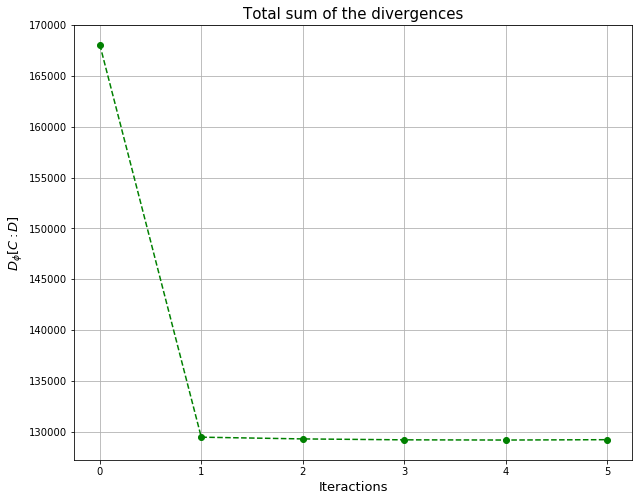

In [48]:
plt.figure(figsize=(10,8))
plt.plot(range(kmeans.get_last_iter()), kmeans.get_sum_total_div(), '--o', c='g')
plt.title('Total sum of the divergences', fontsize=15)
plt.ylabel(r'$D_{\phi}[C: D]$', fontsize=13)
plt.xlabel(r'Iteractions', fontsize=13)
plt.grid()
plt.show()

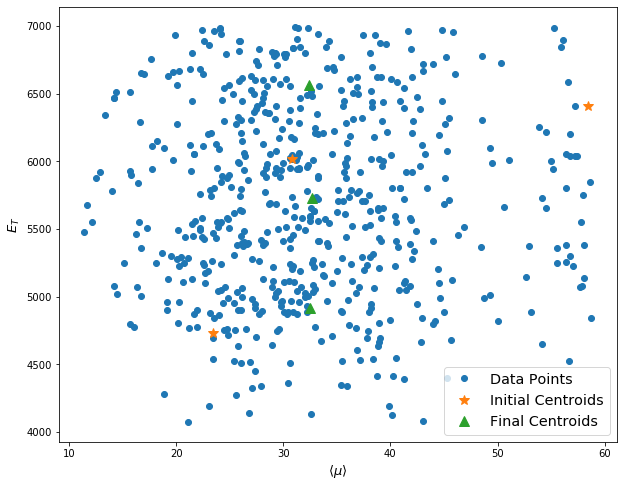

In [49]:
plt.figure(figsize=(10,8))
plt.plot(data_[:,0], data_[:,1], 'o', label='Data Points')
plt.plot(kmeans.get_first_centroids()[:,0], kmeans.get_first_centroids()[:,1], '*',
         markersize=10, label='Initial Centroids')
plt.plot(kmeans.get_centroids()[:,0], kmeans.get_centroids()[:,1], '^',
         markersize=10, label='Final Centroids')
plt.legend(loc='best', fontsize='x-large')
plt.xlabel(r'$\langle\mu\rangle$', fontsize=13)
plt.ylabel(r'$E_T$', fontsize=13)
plt.show()

In [50]:
centers = kmeans.get_centroids()
# Get the Voronoi diagrams
vor = Voronoi(centers)

In [51]:
ax_lim = [np.min(data_, axis=0), np.max(data_, axis=0)]

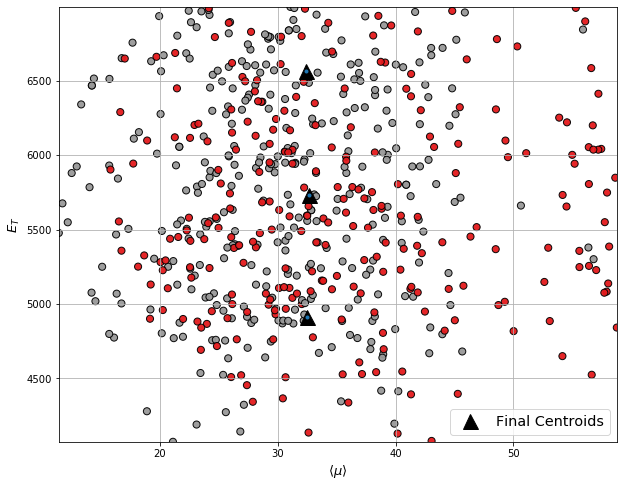

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(10,8))
# Draw data using target to colorize them
axes.scatter(data_[:, 0], data_[:, 1], c=y, cmap='Set1',
             edgecolor='k', s=50, alpha=.95)
# Draw the centroids
axes.plot(centers[:,0], centers[:,1], '^', c='black', markersize=15, label='Final Centroids')
# Draw voronoi
voronoi_plot_2d(vor, ax=axes, show_vertices=True)
plt.grid()
plt.legend(loc='best', fontsize='x-large')
plt.xlim([ax_lim[0][0], ax_lim[1][0]])
plt.ylim([ax_lim[0][1], ax_lim[1][1]])
plt.xlabel(r'$\langle\mu\rangle$', fontsize=13)
plt.ylabel(r'$E_T$', fontsize=13)
plt.show()